Danny Abraham
<center><h1>CMPS 351</h1></center>
<center><h2>Assignment 7</h2></center>

In [1]:
import numpy as np
from numpy import linalg as la
from scipy.optimize import linprog as lp
import matplotlib.pyplot as plt
import scipy.fftpack
import random
import cvxpy as cvx

## LP Solution
---

#### Lagrangian

<img src='1_lagrangian.png'>

#### Primal Problem

<img src='1_primal.png'>

#### Primal Problem Matrix Notation

<img src='1_primal2.png'>

#### Dual Problem

<img src='1_dual.png'>

#### KKT Conditions

In [120]:
def kkt(x, l):
    kkt = []
    kkt.append(-x[0] <= -2)
    kkt.append(-x[0] - 2*x[1] <= -5)
    kkt.append(-2*x[0] -5*x[1] <= -8)
    kkt.append((l >= 0).all())
    kkt.append(l[0]*(-x[0] + 2) == 0)
    kkt.append(l[1]*(-x[0] - 2*x[1] + 5) == 0)
    kkt.append(l[2]*(-2*x[0] -5*x[1] + 8) == 0)
    return kkt

In [124]:
x = np.array([2, 1.5])
l = np.array([1, 4, 0])
kkt(x, l)

[True, True, True, True, True, True, True]

In [129]:
p = np.array([5, 8])
b = np.array([-2, -5, -8])

duality_gap = p@x + b@l
print(duality_gap)

0.0


The duality gap is equal to zero, both problems have the same optimal value

#### Perturbation

Considering a perturbation of the right hand side of the first constraint to -1.9. We are given l\[0\] as 1. Therefor we expect a change of +0.1 in the constraint to cause a change of -0.1 in the optimal value which will be 21.9 

Considering a perturbation of the right hand side of the third constraint to -8.1. We are given l\[1\] as 0. Therefor we expect a change of +0.1 in the constraint to cause a no change in the optimal value which will still be 22.0 

## Contact Problem in 1D
---

In [7]:
k = np.array([1, 10, 2])
l = 1
w = 0.2

In [8]:
def f_obj(x):
    return 0.5*k[0]*(x[0]**2) + 0.5*k[1]*((x[1] - x[0])**2) + 0.5*k[2]*((l - x[1])**2)

In [9]:
x = cvx.Variable(2)

In [10]:
def constraints_(x):
    c = []
    c.append(x[0] >= 0.5*w)
    c.append(x[1] - x[0] >= w)
    c.append(l - x[1] >= 0.5*w)
    return c

In [11]:
constraints = constraints_(x)
obj = cvx.Minimize(f_obj(x))
prob = cvx.Problem(obj, constraints)
prob.solve()

0.4133333333333331

In [12]:
x.value

array([0.53333333, 0.73333333])

In [13]:
for c in constraints:
    print(c.dual_value)

0.0
1.4666666666666655
0.0


These multipliers represent the sesitivity of the objective function to a change in the width of the blocks

In [14]:
c = np.array([2, 4])

In [15]:
def f_obj_deform(x, w_):
    return 0.5*k[0]*(x[0]**2) + 0.5*k[1]*((x[1] - x[0])**2) + 0.5*k[2]*((l - x[1])**2) \
            + (1/2*c[0])*((w_[0] + w_[1] - w)**2) \
            + (1/2*c[1])*((w_[2] + w_[3] - w)**2)

In [16]:
x = cvx.Variable(2)
w_ = cvx.Variable(4)

In [17]:
def constraints_(x, w_):
    c = []
    c.append(x[0] >= w_[0])
    c.append(x[1] - x[0] >= w_[1] + w_[2])
    c.append(l - x[1] >= w_[3])
    c.append(w_[0] <= 0.1)
    c.append(w_[1] <= 0.1)
    c.append(w_[2] <= 0.1)
    c.append(w_[3] <= 0.1)
    c.append(w_[0] >= 0)
    c.append(w_[1] >= 0)
    c.append(w_[2] >= 0)
    c.append(w_[3] >= 0)
    return c

In [18]:
constraints = constraints_(x, w_)
obj = cvx.Minimize(f_obj_deform(x, w_))
prob = cvx.Problem(obj, constraints)
prob.solve()

0.32370370370370366

In [19]:
x.value

array([0.61481481, 0.69259259])

In [20]:
w_.value

array([0.1       , 0.01851852, 0.05925926, 0.1       ])

In [21]:
for c in constraints:
    print(c.dual_value)

0.0
0.1629629629629629
0.0
0.1629629629629629
0.0
0.0
0.1629629629629629
0.0
0.0
0.0
0.0


## Image Reconstruction Revisited
---

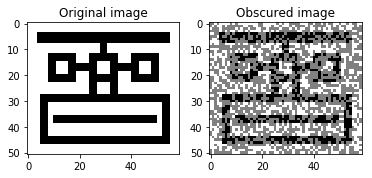

In [2]:
# Read a sample image
U0 = plt.imread('bwicon.png')
m, n = U0.shape

# Create 50% mask of known pixels and use it to obscure the original
np.random.seed(7592)                 # seed the randonm number generator (for repeatability)
unknown = np.random.rand(m,n) < 0.5
U1 = U0*(1-unknown) + 0.5 *unknown



# Display images
plt.figure(1)
plt.subplot(1, 2, 1)
plt.imshow(U0, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(U1, cmap='gray')
plt.title('Obscured image')
plt.show()

In [3]:
ux, uy = U1.shape

In [4]:
def L1_norm(u):
    s = 0
    for i in range(1, ux):
        for j in range(1, uy):
            s += abs(u[i][j] - u[i-1][j]) + abs((u[i][j] - u[i][j-1]))
    return s

In [5]:
B = np.zeros([ux*uy, ux*uy])
for i in range(uy, ux*uy):
    if i%uy != 0:
        B[i][i] = 1
        B[i][i-1] = -1 

In [6]:
C = np.zeros([ux*uy, ux*uy])
for i in range(uy, ux*uy):
    if i%uy != 0:
        C[i][i] = 1
        C[i][i-uy] = -1 

In [7]:
x = U1.flatten()

In [8]:
B_ub = np.zeros(4*ux*uy)
A_ub = np.zeros([4*ux*uy, 3*ux*uy])

A_ub[0:ux*uy, 0:ux*uy] = B
A_ub[ux*uy:2*ux*uy, 0:ux*uy] = -B
A_ub[0:ux*uy, ux*uy:2*ux*uy] = -np.identity(ux*uy)
A_ub[ux*uy:2*ux*uy, ux*uy:2*ux*uy] = -np.identity(ux*uy)

A_ub[2*ux*uy:3*ux*uy, 0:ux*uy] = C
A_ub[3*ux*uy:4*ux*uy, 0:ux*uy] = -C
A_ub[2*ux*uy:3*ux*uy, 2*ux*uy:3*ux*uy] = -np.identity(ux*uy)
A_ub[3*ux*uy:4*ux*uy, 2*ux*uy:3*ux*uy] = -np.identity(ux*uy)

In [9]:
A_eq = np.zeros([ux*uy,3*ux*uy])
B_eq = np.zeros([ux*uy])
unknown2 = unknown.flatten()
x = U1.flatten()
for i in range(ux*uy):
    if not unknown2[i]:
        A_eq[i][i] = 1
        B_eq[i] = x[i]

In [10]:
obj = np.zeros(3*ux*uy)
obj[ux*uy:] = np.ones(2*ux*uy)

In [12]:
res = lp(obj, A_eq=A_eq, b_eq=B_eq, A_ub=A_ub, b_ub=B_ub, options={"disp": True}, method='interior-point')

Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 6018.0              
0.6375661631591     0.6375661631591     0.6375661631591     0.3758205487603  0.6375661631591     3425.658411165      
0.2727436078755     0.2727436078755     0.2727436078755     0.5836467223876  0.2727436078755     1629.29439874       
0.1054429048606     0.1054429048606     0.1054429048606     0.6312325037131  0.1054429048606     994.0502499014      
0.01791546604316    0.01791546604317    0.01791546604317    0.8391015706486  0.01791546604317    710.1659140639      
3.634504843227e-05  3.634504843231e-05  3.634504843226e-05  0.9997322587388  3.634504843236e-05  656.117741571       
1.818497659929e-09  1.818497680763e-09  1.818497711278e-09  0.9999499658404  1.818497699082e-09  656.0000058909      
Optimization terminated successfully.
         Current fu

In [13]:
print(res)

     con: array([0., 0., 0., ..., 0., 0., 0.])
     fun: 656.0000058908898
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([5.74883491e-10, 5.74883491e-10, 5.74883491e-10, ...,
       1.21679381e-09, 1.19136634e-09, 1.11164683e-09])
  status: 0
 success: True
       x: array([4.74686056e-01, 1.00000000e+00, 1.00000000e+00, ...,
       1.14668589e-09, 1.14231159e-09, 1.13962290e-09])


In [14]:
x = res.x[:ux*uy]
x = x.reshape([ux,uy])

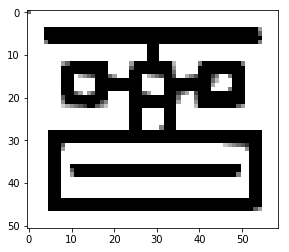

In [15]:
plt.imshow(x, cmap='gray')

## Compressed Sensing
---

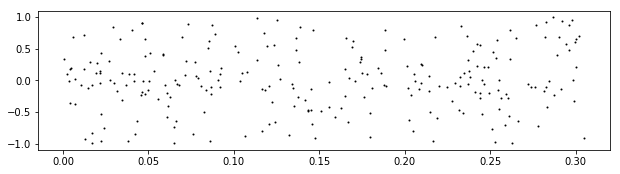

In [25]:
n = 2500
m = 250
fs = 8192                              # sampling frequency 
t = np.arange(n) / fs
y = ( np.sin(2*np.pi*521*t) + np.sin(2*np.pi*1233*t) ) /2.0

D = scipy.fftpack.dct(np.eye(n), norm='ortho').transpose()
k = sorted(random.sample(range(n), m)) # Pick m random points for the reconstruction
A = D[k, :]
b = y[k]

plt.figure(figsize=(10.24, 2.56))      # change aspect ratio of plot 
plt.plot(t[k], b, 'ko', markersize=1)  # plot data to use to reconstruct
plt.show()

#### L2 Norm

In [38]:
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 2))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

C:\Users\Danny\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:781: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:



ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+03  2e-01  2e-06  1e+00  7e+02    ---    ---    1  1  - |  -  - 
 1  +7.772e-03  +8.045e-02  +2e+01  4e-03  3e-08  9e-02  1e+01  0.9849  1e-04   3  2  2 |  0  0
 2  +4.133e+00  +4.299e+00  +4e+00  6e-04  4e-09  2e-01  2e+00  0.8491  2e-02   4  5  5 |  0  0
 3  +7.658e+00  +7.679e+00  +1e-01  2e-05  6e-11  2e-02  6e-02  0.9890  9e-03   4  6  6 |  0  0
 4  +7.767e+00  +7.767e+00  +1e-03  3e-07  9e-13  2e-04  7e-04  0.9890  1e-04   4  4  4 |  0  0
 5  +7.768e+00  +7.768e+00  +1e-05  5e-09  2e-14  3e-06  8e-06  0.9890  1e-04   4  3  3 |  0  0
 6  +7.768e+00  +7.768e+00  +1e-07  2e-10  2e-16  3e-08  9e-08  0.9890  1e-04   4  3  3 |  0  0
 7  +7.768e+00  +7.768e+00  +2e-09  3e-11  1e-17  3e-10  9e-10  0.9890  1e-04   4  2  2 |  0  0

OPTIMAL (within feastol=3.1e-11, reltol=2.0e-

In [39]:
x = np.array(vx.value)
x = np.squeeze(x)
sig = scipy.fftpack.idct(x, norm='ortho', axis=0)

(0, 0.05)

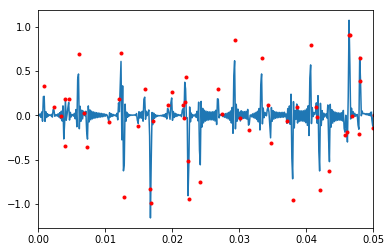

In [40]:
plt.plot(t, sig)
plt.plot(t[k], b, 'ko', markersize=3, color='red')  # plot data to use to reconstruct
plt.xlim((0,0.05))

#### L1 Norm

In [41]:
vx = cvx.Variable(n)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)

C:\Users\Danny\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:781: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:
C:\Users\Danny\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:782: RuntimeWarning: overflow encountered in long_scalars
  self.max_big_small_squared = big*small**2


-----------------------------------------------------------------
           OSQP v0.5.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2018
-----------------------------------------------------------------
problem:  variables n = 5000, constraints m = 5250
          nnz(P) + nnz(A) = 634948
settings: linear system solver = qdldl,
          eps_abs = 1.0e-04, eps_rel = 1.0e-04,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on

objective    pri res    dua res    rho        time
   1  -2.0000e+04   8.00e+00   1.39e+05   1.00e-01   4.61e-01s
 200   1.0758e+02   1.17e-02   4.31e-03   1.00e-01   1.28e+00s
 400   1.0819e+02   4.08e-03   1.10e-03   1.00e-01   1.88e+00s
 

In [42]:
x = np.array(vx.value)
x = np.squeeze(x)
sig = scipy.fftpack.idct(x, norm='ortho', axis=0)

(0, 0.05)

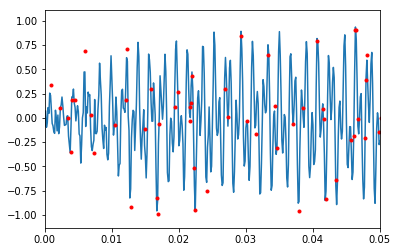

In [43]:
plt.plot(t, sig)
plt.plot(t[k], b, 'ko', markersize=3, color='red')  # plot data to use to reconstruct
plt.xlim((0,0.05))